# Replication Study: Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations
Mihir Singh

## Abstract
This blog post seeks to replicate the study [*Dissecting racial bias in an algorithm used to manage the health of populations*](https://www.science.org/doi/full/10.1126/science.aax2342) by Obermeyer et al (2019). It does this by analyzing and recreating figures 1 and 3 of the paper, as well as further analyzing potential racial disparity between white and black patients with fewer than 5 active chronic illnesses. Like the original study, this blog post finds that the algorithm employed for the purposes of enrolling patients into an intensive care program gives black patients lower risk scores than similar white patients, thus making it so black patients must be sicker than white patients to be enrolled. This disparity likely stems from the algorithm's reliance on healthcare spending as a indirect measurement for health, since black patients often receive less care than white patients and therefore have lower medical expenditures.

## Part A: Data Access
In order to replicate this study, we need to use a randomized version of the data provided by the authors of the original study. This data preserves the same patterns and trends as the study without providing the real patient data used by the authors.

In [204]:
# Imports and data access
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

Let's take a look at our dataframe to see what labels we will be working with.

In [205]:
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


We can see that the dataframe contains useful information like race, whether or not the patient was enrolled in the care program, as well as other health data.

Now that we have data, we can begin working on replicating the actual findings of the paper. 

## Part B: Reproducing Figure 1
We will start with figure 1 of the study which showed the number of chronic illnesses versus the algorithm-predicted risk, by race. The authors decided to plot this to understand if there were racial health disparities conditional on risk score.

<Axes: title={'center': 'Risk Score vs Number of Chronic Illnesses'}, xlabel='Algorithm Risk Score Percentile', ylabel='Mean Num of Chronic Illnesses'>

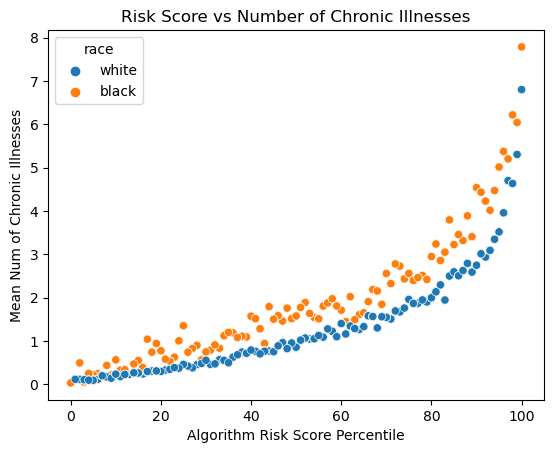

In [206]:
# Plotting figure 1 

# get risk scores as percentile
df["risk_percentile"] = (df["risk_score_t"].rank(pct=True) * 100).round()

# get mean number of chronic illnesses and store in new dataframe
df['mean_num_CI'] = df.groupby(['risk_percentile', 'race'])['gagne_sum_t'].transform('mean')

# plotting
fig, axs = plt.subplots(1,1)
axs.set_title("Risk Score vs Number of Chronic Illnesses")
axs.set_xlabel("Algorithm Risk Score Percentile")
axs.set_ylabel("Mean Num of Chronic Illnesses")
sns.scatterplot(ax = axs,data=df,x='risk_percentile',y='mean_num_CI', hue='race')


This plot shows us that there is indeed a racial disparity between the algorithm's risk score and the number of chronic illnesses a patient might have. We can see that black patients often have a higher number of chronic illnesses compared to white patients in the same risk score percentile. This means that if Patient A is Black, Patient B is White, and both patients have the exact same number of chronic illnesses, Patient A will likely receive a higher risk score from the algorithm and thus be more likely to be referred to the care management program.

## Part C: Reproducing Figure 3
We can now look at reproducing figure 3 of the study which compared the mean total medical expenditure to percentile of the algorithm's risk score as well as the mean total medical expenditure to the number of chronic illnesses a patient had. The authors decided to plot these comparisons to determine if there was any racial disparity in cost for healthcare and as a way to check if there was any disparity in the amount of care received between black and white patients.

<Axes: xlabel='Number of Chronic Illnesses', ylabel=' '>

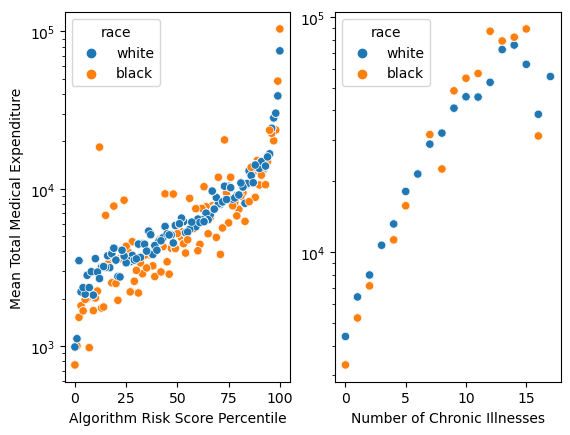

In [207]:
# Plotting Figure 3

# get risk percentile
df['risk_percentile'] = (df['risk_score_t'].rank(pct=True)*100).round()

# get mean expenditure
df["cost_by_RS"] = df.groupby(['risk_percentile','race'])['cost_t'].transform('mean')

# get mean cost of patient healthcare by number of chronic illness
df["cost_by_CI"] = df.groupby(['gagne_sum_t','race'])['cost_t'].transform('mean')

# plotting
fig, axs = plt.subplots(1,2)
axs[0].set_yscale('log')
axs[0].set_xlabel("Algorithm Risk Score Percentile")
axs[0].set_ylabel("Mean Total Medical Expenditure")
axs[1].set_yscale('log')
axs[1].set_xlabel("Number of Chronic Illnesses")
axs[1].set_ylabel(" ")
sns.scatterplot(ax=axs[0],data=df,x='risk_percentile',y='cost_by_RS', hue='race')
sns.scatterplot(ax=axs[1],data=df,x='gagne_sum_t',y='cost_by_CI', hue='race')

These plots show us that as the number of chronic illnesses increase or as your risk score increases, the higher the cost of healthcare is for a patient. This is not particularly surprising since those with higher risk scores are generally less healthy and patients with more chronic illnesses will have higher care needs. However, it is important to note that these plots still show potential evidence of a racial disparity. Most patients have 5 or fewer chronic illnesses and we see that white patients tend to have higher costs than black patients if they have 5 or fewer chronic illnesses. We also see this trend reflected when comparing our risk score and medical expenditure. We find that white patients with lower risk scores tend to have higher healthcare expenditures than black patients. This phenomenon might point to potential racial bias in access to healthcare, where white patients with lower risk scores receive more treatment or care and in turn have higher medical expenditures.

## Part D: Modeling Cost Disparity
We can now try and quantify the disparity we just observed in patients that have 5 or fewer active chronic conditions.

### Data Prep
To do so, we need to first determine the percentage of patients with 5 or fewer chronic conditions. If this percentage is small, it might not be worth focusing on these patients.

In [208]:
# Determining percentage of patients with 5 or fewer active chronic conditions
percentage = len(df.loc[df['gagne_sum_t'] <= 5])/ len(df) * 100
percentage

95.53952115447689

95.5% of patients have five or fewer active chronic conditions, so it does indeed make sense to focus on these patients since any racial disparities occurring within this subgroup of patients will be affecting an overwhelming majority of the people receiving healthcare.

Because medical costs can vary by orders of magnitude, we will want to look at the logorithm of the cost. However, in order to do this we also need to drop any patients who did not have any medical cost at all since log(0) is undefined.

In [209]:
# Log-transform of cost
df_transform = (df.loc[df['cost_t'] > 0]).copy()
df_transform['log_cost'] = np.log(df_transform['cost_t'])

It might also make it easier for us to do some modeling by creating a one-hot encoded column for the qualitative race variable. For us 1 means the patient is black and 0 means they are white.

Then we will separate the data into predictor variables X and target variables Y. Our predictor variables are race and the number of active chronic conditions.

In [210]:
# one-hot encoding of race
df_transform['race_binary'] = (df_transform['race'] == 'black') * 1

# separation of data into predictor variables and target variables
df_X = df_transform[['race_binary','gagne_sum_t']]
df_y = df_transform['log_cost']


### Modeling
With our data prepped, we can now employ a linear regression model. However, our relationship is non-linear, so we will add polynomial features to our model. If we are going to do this, we must also determine how many polynomial features we will use. We can do this with some cross validation. For our purposes we will look from degree 1 to 20.

In [233]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

LR = LinearRegression()
scores = []
for i in range(20):
  X_poly = add_polynomial_features(df_X,i)
  #LR.fit(X_poly, df_y)
  cross_valscore = cross_val_score(LR, X_poly, df_y)
  score = (f"degree {i+1}",cross_valscore.mean())
  scores.append(score) 

scores.sort(key=lambda x: x[1])
scores

[('degree 19', 0.10908769701215384),
 ('degree 20', 0.10940809669337344),
 ('degree 18', 0.1193285359520339),
 ('degree 17', 0.12852193502774437),
 ('degree 16', 0.1442007114428923),
 ('degree 3', 0.14537952700038775),
 ('degree 1', 0.14538846793594346),
 ('degree 2', 0.14538846793594346),
 ('degree 5', 0.146909632661908),
 ('degree 4', 0.14699336604386143),
 ('degree 6', 0.1473340656385787),
 ('degree 7', 0.14776094174784324),
 ('degree 15', 0.148069648494553),
 ('degree 8', 0.1480739986116853),
 ('degree 9', 0.14811660549076067),
 ('degree 10', 0.14820529985520275),
 ('degree 12', 0.14824297239083922),
 ('degree 13', 0.1482567134543757),
 ('degree 14', 0.14828133604468716),
 ('degree 11', 0.14830062340213399)]

Degree 11 seems to have the highest score, so we will use that. Now we will run our model

In [237]:
# final model
new_LR = LinearRegression()
new_df_X = add_polynomial_features(df_X, 11)
new_LR.fit(new_df_X, df_y)

print(new_df_X.columns)
new_LR.coef_

Index(['race_binary', 'gagne_sum_t', 'poly_1', 'poly_2', 'poly_3', 'poly_4',
       'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9', 'poly_10'],
      dtype='object')


array([-2.66958964e-01,  6.12454343e-01,  6.12451935e-01, -1.49609200e+00,
        9.79709805e-01, -3.45158893e-01,  7.23069132e-02, -9.40470735e-03,
        7.65069325e-04, -3.78086925e-05,  1.03681896e-06, -1.20918699e-08])

We see that our race coefficient is the first column of our X and therefore is the first coefficient in our linear regression. Now we calculate our wb.

In [240]:
wb = np.exp(new_LR.coef_[0])
wb

0.7657044921324225

After running our model, we find that the cost incurred by black patients is about 76.5% that of white patients when considering patients with 5 or fewer chronic conditions. This finding supports the argument of Obermeyer et al. that black patients generate lower costs because they might not receive healthcare due to racial biases.

## Discussion
Like the original study, I found that there exists a racial bias in this algorithm. Black patients with the same risk score as white patients often have lower risk scores, making it harder for them to be enrolled into an intensive care program. While there does not seem to be racial disparity in the costs of healthcare for each patient predicted by the algorithm, there might be evidence that black patients receive less healthcare than a white patient in the same health. This racial bias in turn influences black and white patients with regards to medical expenditures. Black patients have lower medical expenditures than white patients who are just as sick. Therefore, we might find racial bias in the algorithm since it bases it risk predictions off the predicted cost of healthcare for a patient, which we just established as also biased by race.